In [1]:
!pip install numpngw imutils
!pip install moviepy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25856 sha256=5dc17340a130b8b9d654809aab1efb9f468f54ec9648bf6bcbad6889112fcdca
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils


Load libraries

In [1]:
import cv2
import json
import numpy as np
import imutils
import sys
import time
import json
import matplotlib
import matplotlib.pyplot as plt
import math
from lib.utils.common_draw_skeletons import *
import pandas as pd
import xml.etree.ElementTree as ET

## Initalization and utilitary functions

Initalization of variables

In [2]:
#initialize jobs
mvt = "cacheTete"
# mvt = "etirementLateraux"
# mvt = "rotationTronc"

path_openpose='dataSampleKeraal/G3-OP-ELK-P1T1-Unknown-C-0.json'
path_alphapose='dataSampleKeraal/G3-AP-ELK-P1T1-Unknown-C-0.json'
path_blazepose='dataSampleKeraal/G3-BP-ELK-P1T1-Unknown-C-0.json'
path_kinect='dataSampleKeraal/G3-Kinect-ELK-P1T1-Unknown-C-0.txt'
path_vicon='dataSampleKeraal/G3-Vicon-ELK-P1T1-Unknown-C-0.txt'



height=300
width=500
size=(width,height)


Functions to read the data files

In [3]:
#read Json openpose file
def read_json_openpose(path, Body_parts_strToNum):
    with open(path,'r') as f:
        data=f.read()
    
        for i in Body_parts_strToNum:
            data=data.replace(i,str(Body_parts_strToNum[i]))
        json_object=json.loads(data)
    f.close()
    return json_object

#read Json alphapose file
def read_json_alphapose(path):
    with open(path,'r') as f:
        data=f.read()
        json_object=json.loads(data)
        #print(json_object["positions"].keys()) #the frame numbers
        #for key in json_object["positions"].keys(): #printing  the joint positions for each frame
        #    print("key ", key," ", json_object["positions"][key])
    f.close()
    return json_object

#read Kinect txt file and map it to the correct json format
def read_txt_kinect(path):
    with open(path_kinect,'r') as f:
        data = f.read().splitlines()
    f.close()

    tab = {}
    tab1 = {}
    tab1['positions'] = tab

    line = 0
    for i in data:
        line = line+1
        tab[str(float(line))] = {}
        for n in range(25):
            first = i.split(' ')[7*n:7*(n+1)]
            tab[str(float(line))][str(n)] = [first[0], first[1]]
    return tab1

#read Vicon txt file and map it to the correct json format
def read_txt_vicon(path):
    tab= {}
    tab1= {}
    tab1['positions'] = tab
    data_filtred=[]
    
    #read file
    with open(path_vicon,'r') as w:
        data = w.read().splitlines()
    w.close()
    for j in range(0,len(data)):
        if j%2 == 0:
            data_filtred.append(data[j])
#     print(len(data_filtred))
    data = data_filtred
    

#     print('start vicon')
    line=0
    for i in data:
        line=line+1
        tab[str(float(line))]={}
        for n in range(17):
            first=i.split(' ')[7*n:7*(n+1)]
            tab[str(float(line))][str(n)] = [first[0],first[1],first[2],first[3],first[4],first[5],first[6]]
    return tab1



Angles conversion

In [4]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return [roll_x,pitch_y,yaw_z]

## Functions to draw skeletons

In [5]:
#cocopairs for openpose	
CocoPairs = [
             (1, 2), (1, 5), (2, 3), (3, 4), (5, 6), (6, 7), (1, 8),
             (8, 9), (9, 10), (1, 11),(11, 12), (12, 13), (1, 0), 
             (0, 14), (14, 16), (0, 15), (15, 17), (2, 16), (5, 17)]   
CocoPairsRender = CocoPairs[:-2]
    
#Draw human skeleton function for openpose 
def draw_humans(npimg, humans, CocoColors_parts, CocoColors_pairs):

    
    image_h, image_w = npimg.shape[:2]
#     print(image_h, image_w)
    
    centers = {}
    human_keys=list(map(int, humans.keys()))
        
    # draw point
    for i in range(CocoPart.Background.value):#for each keypoint
            if i not in human_keys:
                continue
            
            body_part = humans[str(i)]
            center = (int(body_part[0] * image_w)-80, int(body_part[1] * image_h + 0.5))
            centers[i] = center
            if(i==1):
                cv2.circle(npimg, center, 9, CocoColors_parts[i], thickness=2, lineType=8, shift=0)
            else:
                cv2.circle(npimg, center, 3, CocoColors_parts[i], thickness=2, lineType=8, shift=0)

    # draw line
    for pair_order, pair in enumerate(CocoPairsRender):
#             print(pair_order, pair[1])
            
            if pair[0] not in human_keys or pair[1] not in human_keys:
                continue
#             print(pair, centers[pair[0]], centers[pair[1]], CocoColors_pairs[pair])
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], CocoColors_pairs[pair], 2)

    return npimg

In [6]:
def convertir_blazepose_en_openpose(bla_temp, dic):
    sklt_bla = list(bla_temp.keys())
#     deep_ref = (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2
    blaztoOpen = {}
    blaztoOpen[str(dic["Nose"])] = np.array(bla_temp[sklt_bla[0]])
    blaztoOpen[str(dic["Neck"])] = np.array([(bla_temp[sklt_bla[11]][0]+bla_temp[sklt_bla[12]][0])/2,
                                        (bla_temp[sklt_bla[11]][1]+bla_temp[sklt_bla[12]][1])/2,
                                        (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2])
    ## Right arm
    blaztoOpen[str(dic["rShoulder"])] = np.array(bla_temp[sklt_bla[12]])
    blaztoOpen[str(dic["rElbow"])] = np.array(bla_temp[sklt_bla[14]])
    blaztoOpen[str(dic["rWrist"])] = np.array(bla_temp[sklt_bla[16]])
    ## Left arm
    blaztoOpen[str(dic["lShoulder"])] = np.array(bla_temp[sklt_bla[11]])
    blaztoOpen[str(dic["lElbow"])] = np.array(bla_temp[sklt_bla[13]])
    blaztoOpen[str(dic["lWrist"])] = np.array(bla_temp[sklt_bla[15]])
    ## Right leg
    blaztoOpen[str(dic["rHip"])] = np.array(bla_temp[sklt_bla[24]])
    blaztoOpen[str(dic["rKnee"])] = np.array(bla_temp[sklt_bla[26]])
    blaztoOpen[str(dic["rAnkle"])] = np.array(bla_temp[sklt_bla[28]])
    ## Left leg
    blaztoOpen[str(dic["lHip"])] = np.array(bla_temp[sklt_bla[23]])
    blaztoOpen[str(dic["lKnee"])] = np.array(bla_temp[sklt_bla[25]])
    blaztoOpen[str(dic["lAnkle"])] = np.array(bla_temp[sklt_bla[27]])

    return blaztoOpen  

In [7]:
# Draw human skeleton function for Kinect
Body_parts_kinect={0: 'SpineBase' ,1: 'SpineMid',2: 'Neck',3: 'Head',
                       4: 'ShoulderLeft',5: 'ElbowLeft',6: 'WristLeft',7: 'HandLeft',
                       8: 'ShoulderRight',9: 'ElbowRight',10: 'WristRight',
                       11: 'HandRight',12: 'HipLeft',13: 'KneeLeft',14: 'AnkleLeft',
                       15: 'FootLeft',16: 'HipRight',17: 'KneeRight',18: 'AnkleRight',
                       19: 'FootRight',20: 'SpineShoulder',21: 'HandTipLeft',
                       22: 'ThumbLeft',23: 'HandTipRight',24: 'ThumbRight'}
    
# Defining the skeletons pairs
CocoPairsRender_kn = [(0,1),(1,2),(2,3), (2,4),(4,5),(5,6),(6,7),
                    (2,8),(8,9),(9,10),(10,11),(0,12),(12,13),(13,14),
                    (14,15),(0,16),(16,17),(17,18),(18,19)]

def draw_humans_kinect(npimg, humans):

    image_h, image_w = npimg.shape[:2]
#     print(image_h, image_w)
    
    centers = {}
    human_keys=list(map(int, humans.keys()))
#     print(human_keys)
   
    # draw point
    for i in range(len(CocoColors_parts_kn)-1):
            if i not in human_keys:
#                 print (i)
                continue
            
            body_part = sklt[str(i)]
            center = (image_w-int((float(body_part[0]) * image_w + 200)/3.5+100), int((float(body_part[1]) * image_h + 200)/3.5+100))
            centers[i] = center
#             print(center)
            
            cv2.circle(npimg, center, 3, CocoColors_parts_kn[i], thickness=2, lineType=8, shift=0)
            
        # draw line
    
#     print(enumerate(CocoPairsRender_kn))
    for pair_order, pair in enumerate(CocoPairsRender_kn):
#             print(pair_order, pair[1])
#             print(pair)
            
            if pair[0] not in human_keys or pair[1] not in human_keys:
                continue
#             print(centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair])
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], CocoColors_pairs_kn[pair], 2)

    return npimg


In [8]:
#Draw human skeleton function for Vicon 

#    CocoPairs_vc=[(8,7),(7,2),(8,1),(2,0),(3,1),(0,9),(3,10),
#                  (14,4),(4,13),(13,5),(13,6),(5,15),(6,16),(11,15),(12,16)]
CocoPairs_vc=[(8,7),(7,2),(8,3),(0,2),(1,3),(0,9),(1,10),
              (14,4),(4,13),(13,5),(13,6),(5,15),(6,16),(11,15),(12,16)]

def draw_vicon_3d(i, image_w, image_h):
    fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    ax = plt.axes(projection='3d')
    X=[]
    Y=[]
    Z=[]
    for j in range(0,len(openpose_coord_vc['positions'][str(float(i))])):
        #print(str(i))
                pos_head=openpose_coord_vc['positions'][str(float(i))][str(0)]
                param_x=0.5*image_w-float(pos_head[0])
                param_y=0.5*image_h-float(pos_head[1])
                md_pt=openpose_coord_vc['positions'][str(float(i))][str(j)]
                #X.append(float(md_pt[0])*image_w/600-param_x)
                #Y.append(float(md_pt[1])*image_h/600-param_y)
                X.append(float(md_pt[0])*image_w/600)
                Y.append(image_h - float(md_pt[1])*image_h/600-500)
                Z.append(float(md_pt[2])/600)

    res=euler_from_quaternion(float(md_pt[3]),float(md_pt[4]),float(md_pt[5]),float(md_pt[6]))
    ax.scatter3D(X, Y, Z, color=(0,1,0) ,s=53 ,marker='o')
    ax.set_facecolor('xkcd:black')
    ax.set_ylim3d(-400,400)
    #ax.set_xlim3d(30,400)
    ax.set_xlim3d(-200,800)
    
    #ax.set_zlim3d(-40,40)
    for pair in CocoPairs_vc:
        X_pair=[X[pair[0]],X[pair[1]]]
        Y_pair=[Y[pair[0]],Y[pair[1]]]
        Z_pair=[Z[pair[0]],Z[pair[1]]]
        ax.plot(X_pair,Y_pair,Z_pair,color='green',linewidth=5)	
    ax.view_init(res[1], res[0])
    plt.grid(b=None)
    plt.axis('off')
    plt.subplots_adjust(bottom=0.01)
    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,sep='')
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0]
    return img

In [9]:
ap_body_parts = ['nose', 'l_eye', 'r_eye', 'l_ear', 'r_ear', 'l_shoulder',
        'r_shoulder', 'l_elbow', 'r_elbow', 'l_wrist', 'r_wrist',
        'l_hip', 'r_hip', 'l_knee', 'r_knee', 'l_ankle', 'r_ankle']
def convertir_alphapose_en_openpose(bla_temp, dic):
    sklt_bla = list(bla_temp.keys())
#     deep_ref = (bla_temp[sklt_bla[11]][2]+bla_temp[sklt_bla[12]][2])/2
    alphtoOpen = {}
    alphtoOpen[str(dic["Nose"])] = np.array(bla_temp[sklt_bla[0]])
    alphtoOpen[str(dic["Neck"])] = np.array([(bla_temp[sklt_bla[5]][0]+bla_temp[sklt_bla[6]][0])/2,
                                        (bla_temp[sklt_bla[5]][1]+bla_temp[sklt_bla[6]][1])/2
                                        ])
    ## Right arm
    alphtoOpen[str(dic["rShoulder"])] = np.array(bla_temp[sklt_bla[6]])
    alphtoOpen[str(dic["rElbow"])] = np.array(bla_temp[sklt_bla[8]])
    alphtoOpen[str(dic["rWrist"])] = np.array(bla_temp[sklt_bla[10]])
    ## Left arm
    alphtoOpen[str(dic["lShoulder"])] = np.array(bla_temp[sklt_bla[5]])
    alphtoOpen[str(dic["lElbow"])] = np.array(bla_temp[sklt_bla[7]])
    alphtoOpen[str(dic["lWrist"])] = np.array(bla_temp[sklt_bla[9]])
    ## Right leg
    alphtoOpen[str(dic["rHip"])] = np.array(bla_temp[sklt_bla[12]])
    alphtoOpen[str(dic["rKnee"])] = np.array(bla_temp[sklt_bla[14]])
    alphtoOpen[str(dic["rAnkle"])] = np.array(bla_temp[sklt_bla[16]])
    ## Left leg
    alphtoOpen[str(dic["lHip"])] = np.array(bla_temp[sklt_bla[11]])
    alphtoOpen[str(dic["lKnee"])] = np.array(bla_temp[sklt_bla[13]])
    alphtoOpen[str(dic["lAnkle"])] = np.array(bla_temp[sklt_bla[15]])
    #Eyes rEye':14, 'lEye':15
    alphtoOpen[str(dic["rEye"])] = np.array(bla_temp[sklt_bla[2]])
    alphtoOpen[str(dic["lEye"])] = np.array(bla_temp[sklt_bla[1]])
    return alphtoOpen 

In [11]:
# path_openpose='openpose/G1A-OP-CTK-R6-Roscoff-082.json' 
# path_blazepose='blazepose/G1A-BP-CTK-R6-Roscoff-082.json'
# # path_blazepose='blazepose/G1A-BP-CTK-R1-Brest-022.json'
# path_kinect='kinect/G1A-Kinect-CTK-R6-Roscoff-082.txt'
# # path_kinect='kinect/G1A-Kinect-CTK-R2-Brest-008.txt'

In [10]:
# Body_parts_0={0:'Nose',1:'Neck',2:'rShoulder',3:'rElbow',4:'rWrist',5:'lShoulder',6:'lElbow',7:'lWrist',8:'rHip',9:'rKnee',10:'rAnkle',11:'lHip',12:'lKnee',13:'lAnkle',14:'rEye', 15:'lEye',16:'rEar', 17:'lEar'}
Body_parts_strToNum1={'Nose':0 ,'Neck':1 ,'rShoulder':2, 'rElbow':3, 'rWrist':4, 'lShoulder':5,'lElbow':6,'lWrist':7,'rHip':8,'rKnee':9,'rAnkle':10,'lHip':11,'lKnee':12,'lAnkle':13,'rEye':14, 'lEye':15,'rEar':16, 'lEar':17  }
Body_parts_strToNum2={'Head':0 ,'mShoulder':1 ,'rShoulder':2, 'rElbow':3, 'rWrist':4, 'lShoulder':5,'lElbow':6,'lWrist':7,'rHip':8,'rKnee':9,'rAnkle':10,'lHip':11,'lKnee':12,'lAnkle':13,'rEye':14, 'lEye':15,'rEar':16, 'lEar':17  }

########################Prepare Skeletons data#################################

# openpose_coord = read_json_openpose(path_openpose, Body_parts_strToNum2)
# print(len(openpose_coord["positions"].keys()))

# openpose_coord_kn = read_txt_kinect(path_kinect)
# print(len(openpose_coord_kn["positions"].keys()))

# #read blazepose data
# with open(path_blazepose,"rb") as f:
#     blaze_coord = json.loads(f.read())
# f.close()
# print(len(blaze_coord["positions"].keys()))

In [11]:
import os

# groups = ["group1A","group1B","group2A","group2B","group3"]
# full_list = {}

# for group in groups:
#     folder_path = group + "/blazepose"
#     file_list = []
#     length_list = []
#     error_list = []
#     # Get the list of files in the specified folder
#     for file_name in os.listdir(folder_path):
#         if os.path.isfile(os.path.join(folder_path, file_name)):
#             file_list.append(file_name)

#     for file_name in file_list:
#         path_blazepose=folder_path+ '/'+file_name
#         with open(path_blazepose,"rb") as f:
#             blaze_coord = json.loads(f.read())
#         f.close()
#         size = len(blaze_coord["positions"].keys())
#         if size < 10:
#             error_list.append(file_name)
#         length_list.append(size)
#     full_list.update({group: error_list})
#     print(len(error_list))


In [16]:
print(full_list)

{'group1A': ['G1A-BP-CTK-R6-Roscoff-082.json', 'G1A-BP-ELK-R4-Roscoff-009.json', 'G1A-BP-ELK-R4-Roscoff-036.json', 'G1A-BP-ELK-R6-Roscoff-010.json', 'G1A-BP-ELK-R6-Roscoff-023.json', 'G1A-BP-RTK-R4-Roscoff-014.json', 'G1A-BP-RTK-R4-Roscoff-017.json', 'G1A-BP-RTK-R6-Roscoff-037.json'], 'group1B': ['G1B-BP-CTK-Roscoff-208.json', 'G1B-BP-CTK-Roscoff-209.json', 'G1B-BP-CTK-Roscoff-210.json', 'G1B-BP-CTK-Roscoff-211.json', 'G1B-BP-CTK-Roscoff-212.json', 'G1B-BP-CTK-Roscoff-213.json', 'G1B-BP-CTK-Roscoff-214.json', 'G1B-BP-CTK-Roscoff-218.json', 'G1B-BP-CTK-Roscoff-220.json', 'G1B-BP-CTK-Roscoff-222.json', 'G1B-BP-CTK-Roscoff-223.json', 'G1B-BP-CTK-Roscoff-224.json', 'G1B-BP-CTK-Roscoff-227.json', 'G1B-BP-CTK-Roscoff-262.json', 'G1B-BP-CTK-Roscoff-264.json', 'G1B-BP-CTK-Roscoff-265.json', 'G1B-BP-CTK-Roscoff-266.json', 'G1B-BP-CTK-Roscoff-267.json', 'G1B-BP-CTK-Roscoff-268.json', 'G1B-BP-CTK-Roscoff-269.json', 'G1B-BP-CTK-Roscoff-270.json', 'G1B-BP-CTK-Roscoff-271.json', 'G1B-BP-CTK-Roscoff-

In [14]:
# # Open the file in read mode
# filename = 'group1A/annotatorA/G1A-CTK-R1-Brest-022.anvil'
# text_content = ""

# with open(filename, 'rb') as file:
#     file_content = file.read()

#     # Filter out null bytes
#     filtered_content = file_content.replace(b'\x00', b'')

#     # Decode the filtered content as UTF-8
#     text_content = filtered_content.decode('latin-1')

# print(text_content)

In [12]:
import re

# # Define the regular expression pattern to match the format
# pattern = r'<el index="(\d+)" start="([\d.]+)" end="([\d.]+)">'

# # Use re.search to find the pattern in the larger string
# match = re.search(pattern, text_content)

# if match:
#     matched_substring = match.group(0)
#     start_value = match.group(2)
#     end_value = match.group(3)

#     print(f"Matched Substring: {matched_substring}")
#     print(f"Start Value: {start_value}")
#     print(f"End Value: {end_value}")
# else:
#     print("Pattern not found in the larger string")

In [13]:
from moviepy.editor import VideoFileClip

# video_path = "group1A/videos/G1A-Anon-CTK-R1-Brest-022.mp4"  # Specify the path to your video file here

# # Load the video file
# video = VideoFileClip(video_path)

# # Get the duration of the video (in seconds)
# video_duration = video.duration

# print(f"The duration of the video is: {video_duration} seconds")

# num_frames = video.reader.nframes

# print(f"The number of frames in the video is: {num_frames}")

# # Close the video file
# video.close()


In [18]:
# error_tags = [(0,16.92),(14.8,16.92),(12.08,16.56)]
# json_file_path = "G1A-BP-CTK-R1-Brest-022.json"

# # Read the existing JSON data from the file
# with open(json_file_path, "r") as file:
#     data = json.load(file)

# size = len(data["positions"])
# print(size)
# # Modify the JSON data as needed
# for i in range(size):
#     index = str(i+1)+".0"
#     data["positions"][index]["error"] = False
# for error_tag in error_tags:
#     begin = (int)((error_tag[0] / video_duration)*num_frames)+1
#     end = (int)((error_tag[1] / video_duration)*num_frames)+1
#     if end > size:
#         end = size
#     print(begin,end)
#     for i in range(begin,end+1):
#         index = str(i)+".0"
#         data["positions"][index]["error"] = True

# # Write the updated JSON data back to the file
# with open(json_file_path, "w") as file:
#     json.dump(data, file, indent=4)

# print("JSON file overwritten with updated data.")

In [14]:
import matplotlib.pyplot as plt


# # Plot the values
# plt.plot(length_list)

# # Add labels and title
# plt.xlabel('Index')
# plt.ylabel('Size')

# # Display the plot
# plt.show()

File name: Group(G1A)-Type(BP)-Exercise(CTK)-Patient(R1)-Place(Brest)-record(022)
3 exercise: CTK, ELK, RTK

In [15]:
def readAnnotationFile(path):
	tree = ET.parse(path)
	root = tree.getroot()
	ybin = -1
	ymulti = -1
	for track in root.iter('track'):
		if track.attrib.get('name')=='Global evaluation':
			if track.find('el').find('attribute').text == 'Correct':
				ybin=0
				ymulti=0
				return ybin,ymulti
			else:
				if track.find('el').find('attribute').text == 'Incomplete':
					ybin=1
					ymulti=4
					return ybin,ymulti
				if track.find('el').find('attribute').text == 'Motionless':
					ybin=1
					ymulti=5
					return ybin,ymulti
		else:
			if track.attrib.get('name') =='Global error':
				for attr in track.find('el').iter('attribute'):
					if attr.get('name') == 'type':
						if attr.text == 'Error1':
							ybin=1
							ymulti=1
							return ybin,ymulti
						else:
							if attr.text == 'Error2':
								ybin=1
								ymulti=2
								return ybin,ymulti
							elif attr.text == 'Error3':
								ybin=1
								ymulti=3
								return ybin,ymulti
	return ybin,ymulti

In [17]:
errorNameList = ['Correct','Error1','Error2','Error3','Incomplete','Motionless']
tagList = ['Correct','Error']

In [ ]:
path = "group1A/annotatorA/G1A-CTK-R1-Brest-042.anvil"
result = readAnnotationFile(path)
print(tagList[result[0]]+", "+errorNameList[result[1]])

Error, Error1


In [19]:
groups = ["group1A","group1B","group2A","group2B","group3"]
folders = ["blazepose","kinect","openpose"]
exercises = ["CTK","ELK","RTK"]

# Create an empty DataFrame
dict = {'Group':[],'Exercise':[], 'Patient':[], 'Place':[], 'Record':[], 'BlazePose':[], 'Kinect':[], 'OpenPose':[], 'annotatorA':[], 'annotatorB':[]}

df = pd.DataFrame(dict)
for group in groups:
    folder_path = group + "/" + "blazepose"
    file_list = []
    length_list = []
    error_list = []
    # Get the list of files in the specified folder
    for file_name in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_name)):
            name, data = file_name.split(".")
            columns = name.split("-")
            if len(columns) >= 6:
                if len(columns) == 7:
                    place = columns[4]+'-'+columns[5]
                    record = columns[6]
                else:
                    place = columns[4]
                    record = columns[5]
                newRow = {'Group':columns[0],'Exercise':columns[2], 'Patient':columns[3], 'Place':place, 'Record':record, 'BlazePose':0, 'Kinect':0, 'OpenPose':0, 'annotatorA':'None','annotatorB':'None'}
            else:
                newRow = {'Group':columns[0],'Exercise':columns[2], 'Patient': "None", 'Place':columns[3], 'Record':columns[4], 'BlazePose':0, 'Kinect':0, 'OpenPose':0, 'annotatorA':'None','annotatorB':'None'}
            
            path_openpose = group + "/" + folders[2] + "/" + ('-'.join([columns[0],"OP",columns[2],columns[3],place,record]) if len(columns)>=6 else '-'.join([columns[0],"OP",columns[2],columns[3],columns[4]])) + ".json"
            openpose_coord = read_json_openpose(path_openpose, Body_parts_strToNum2)
            newRow["OpenPose"] = len(openpose_coord["positions"].keys())

            path_kinect = group + "/" + folders[1] + "/" + ('-'.join([columns[0],"Kinect",columns[2],columns[3],place,record]) if len(columns)>=6 else '-'.join([columns[0],"Kinect",columns[2],columns[3],columns[4]])) + ".txt"
            openpose_coord_kn = read_txt_kinect(path_kinect)
            newRow["Kinect"] = len(openpose_coord_kn["positions"].keys())

            path_blazepose = group + "/" + folders[0] + "/" + ('-'.join([columns[0],"BP",columns[2],columns[3],place,record]) if len(columns)>=6 else '-'.join([columns[0],"BP",columns[2],columns[3],columns[4]])) + ".json"
            with open(path_blazepose,"rb") as f:
                blaze_coord = json.loads(f.read())
            f.close()
            newRow["BlazePose"] = len(blaze_coord["positions"].keys())

            if group in ['group1A','group2A']:
                for annotator in ["annotatorA","annotatorB"]:
                    annotation = group + "/" + annotator + "/" + '-'.join([columns[0],columns[2],columns[3],place,record])+'.anvil'
                    # text_content = ""

                    # with open(annotation, 'rb') as file:
                    #     file_content = file.read()

                    #     # Filter out null bytes
                    #     filtered_content = file_content.replace(b'\x00', b'')

                    #     # Decode the filtered content as UTF-8
                    #     text_content = filtered_content.decode('latin-1')
                    # result = text_content.find('<attribute name="evaluation">Correct</attribute>')
                    # if result >= 0:
                    #     newRow[annotator]='Correct'
                    # else:
                    #     newRow[annotator]='Incorrect'
                    result = readAnnotationFile(annotation)
                    newRow[annotator]=errorNameList[result[1]]
            
            df = pd.concat([df, pd.DataFrame([newRow])], ignore_index=True)

In [20]:
print(df)

     Group Exercise Patient         Place Record  BlazePose  Kinect  OpenPose  \
0      G1A      CTK      R1         Brest    022      300.0   300.0     301.0   
1      G1A      CTK      R1         Brest    038      328.0   328.0     329.0   
2      G1A      CTK      R1         Brest    042      318.0   318.0     319.0   
3      G1A      CTK      R1         Brest    054      305.0   305.0     306.0   
4      G1A      CTK      R1         Brest    056      298.0   298.0     299.0   
...    ...      ...     ...           ...    ...        ...     ...       ...   
2616    G3      RTK    P3T3  Unknown-E3B3      0      211.0   212.0     212.0   
2617    G3      RTK    P3T3  Unknown-E3B3      1      214.0   213.0     215.0   
2618    G3      RTK    P3T3  Unknown-E3B3      2      211.0   212.0     212.0   
2619    G3      RTK    P3T3  Unknown-E3B3      3      214.0   213.0     215.0   
2620    G3      RTK    P3T3  Unknown-E3B3      4      213.0   213.0     214.0   

     annotatorA annotatorB 

In [21]:
# Export the DataFrame to a CSV file
df.to_csv('keraalTable.csv', index=False)

# Print a message to confirm the export
print("DataFrame exported to 'keraalTable.csv'")

DataFrame exported to 'keraalTable.csv'


In [2]:
mlist = "0.586347 -0.307980 2.685188 -0.058028 -0.033107 0.982269 -0.175170 0.561269 -0.032902 2.585230 -0.071201 -0.030754 0.981402 -0.175598 0.533508 0.236686 2.473535 -0.083703 -0.033341 0.972825 -0.213294 0.532521 0.381902 2.425871 0.000000 0.000000 0.000000 0.000000 0.375655 0.157753 2.548157 0.220982 0.730505 -0.644306 0.048984 0.311717 -0.112522 2.575804 -0.023640 0.820352 -0.123547 -0.557853 0.311916 -0.322385 2.476865 -0.121014 0.538831 -0.181924 0.813585 0.316790 -0.340709 2.447263 -0.323516 0.462746 -0.367024 0.739254 0.708525 0.145272 2.497020 0.118244 0.738693 0.642465 -0.166105 0.788479 -0.124423 2.517650 -0.037521 0.863698 0.143174 0.481788 0.767388 -0.328167 2.407619 0.116666 -0.285131 -0.219678 0.925652 0.759810 -0.338552 2.395314 0.329094 -0.223259 -0.316078 0.861364 0.501261 -0.306761 2.662125 -0.018352 -0.672782 0.711745 -0.201116 0.307485 -0.409395 2.424095 0.544467 -0.400430 -0.212115 0.705846 0.346563 -0.820175 2.572109 -0.138709 -0.587283 0.110623 0.789697 0.321869 -0.913157 2.493130 0.000000 0.000000 0.000000 0.000000 0.657168 -0.301649 2.643084 -0.068412 0.613890 0.730498 -0.291258 0.774912 -0.409444 2.374731 -0.499595 0.495123 -0.278912 0.653809 0.765485 -0.830392 2.553928 0.129444 0.593617 0.152619 0.779468 0.792130 -0.901615 2.474659 0.000000 0.000000 0.000000 0.000000 0.540891 0.170120 2.503590 -0.084213 -0.030837 0.977142 -0.192743 0.326627 -0.395019 2.399609 0.000000 0.000000 0.000000 0.000000 0.352676 -0.337677 2.452750 0.000000 0.000000 0.000000 0.000000 0.740539 -0.400629 2.362639 0.000000 0.000000 0.000000 0.000000 0.732051 -0.353775 2.420231 0.000000 0.000000 0.000000 0.000000"
group = mlist.split(" ")
print(len(group))

175


In [21]:
#Start plotting skeletons
images=[]
for i in range(1,len(blaze_coord['positions'])):
    #draw blazepose
    black_image_bla = np.zeros((height,width,3), np.uint8)
    sklt_blaze = convertir_blazepose_en_openpose(blaze_coord['positions'][str((float(i)))],Body_parts_strToNum1)
    frame_image_bla = draw_humans(black_image_bla, sklt_blaze, CocoColors_parts_bla, CocoColors_pairs_bla)
    frame_image_bla = cv2.flip(frame_image_bla, 1)
    cv2.putText(frame_image_bla,"Blazepose Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    
    ## draw kinect
    black_image_kn = np.zeros((height,width,3), np.uint8)
    sklt = openpose_coord_kn['positions'][str(float(i))]
    frame_image = draw_humans_kinect(black_image_kn,sklt)
    frame_image_kn = cv2.flip(frame_image, 0)
    cv2.putText(frame_image_kn,"Kinect Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    #draw openpose
    black_image_op = np.zeros((height,width,3), np.uint8)
    sklt = openpose_coord['positions'][str(float(i))]
    frame_image_op = draw_humans(black_image_op,sklt, CocoColors_parts, CocoColors_pairs)
    cv2.putText(frame_image_op,"Openpose Skeleton", (int(width/8),50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    
    glob = np.concatenate((frame_image_bla, frame_image_op, frame_image_kn), axis = 1)
#     print(glob.shape)
#     cv2.imshow("aimage",glob)
    images.append(glob)
    #cv2.imshow("Skeleton",glob)
    #result.write(glob)
    #cv2.waitKey(1)

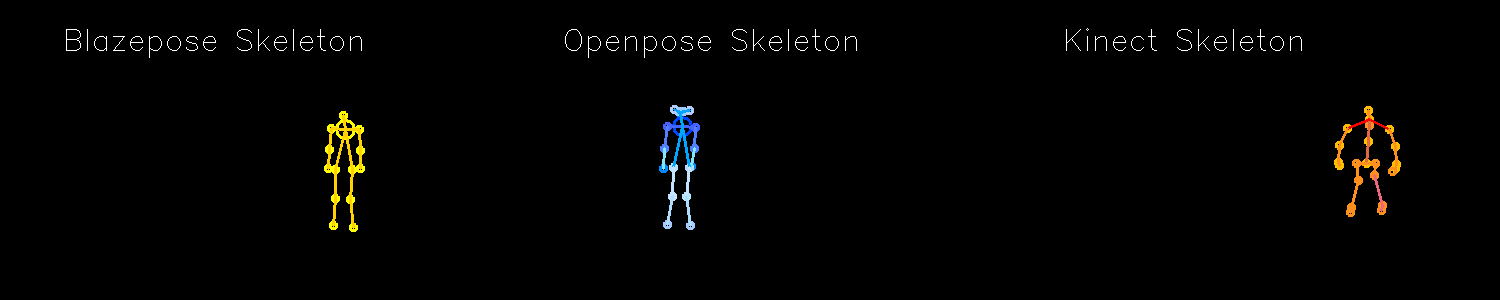

In [22]:
from IPython.display import Image
from numpngw import write_apng

#imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('outvideo.gif', images, delay=60)
Image(filename='outvideo.gif')